# 4 Fitting Circles

In [27]:
# imports

import numpy as np
import scipy as scp
from scipy.sparse import coo_matrix
import scipy.sparse.linalg as linalg
import scipy.io
import matplotlib.pylab as plt
from matplotlib.pyplot import cm

In [3]:
# load data
data = np.load("circles.npy")
data[:,0]

array([0.64454115, 0.36365302, 0.04661327, ..., 0.1193191 , 0.54284675,
       0.66827075])

Text(0.5, 1.0, 'Circle Data')

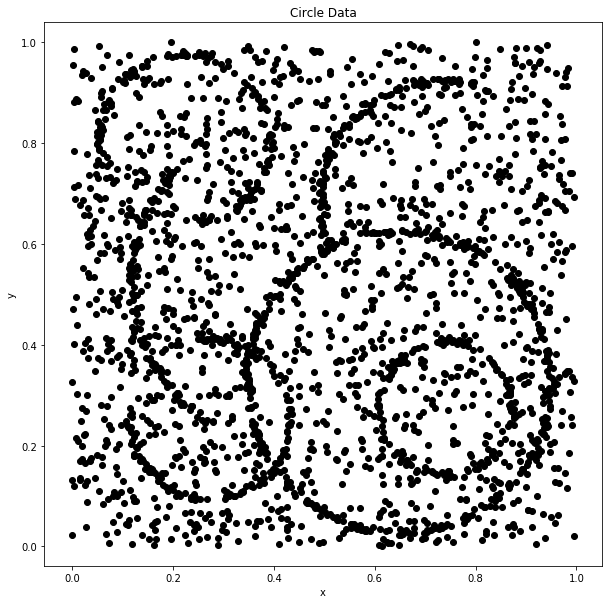

In [4]:
# plot data

plt.figure(figsize=(10,10))
plt.scatter(data[:,0],data[:,1],facecolor='k')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Circle Data')

As a human, I would fit six circles.

## 4.1 RANSAC

For any of the three points it must hold that

$$
r^2 = (x_i-x_{center})^2 + (y_i-y_{center})^2,
$$

where $i  \in{[1,2,3]}$.

Solving the system of the three equation gives
$$
x_{center}=\frac{\sum_{i=1}^{3}{x_i^2 \Delta y_{i+1,i+2}} + \sum_{i=1}^{3}{ y_i^2 \Delta y_{i+1,i+2}}}{2 \sum_{i=1}^{3}{ y_i \Delta y_{i+1,i+2}}},
$$

$$
y_{center}=\frac{\sum_{i=1}^{3}{x_i^2 \Delta x_{i+1,i+2}} + \sum_{i=1}^{3}{ y_i^2 \Delta x_{i+1,i+2}}}{2 \sum_{i=1}^{3}{ y_i \Delta x_{i+1,i+2}}},
$$

such that r can be computed by
$$
r = \sqrt{(x_i-x_{center})^2 + (y_i-y_{center})^2}.
$$

Therby, 
$$
\Delta x_{i,j}= x_j-x_i
$$
and
$$
x_{i+3} = x_i.
$$

In [113]:
def ransac(X,Y,N,e=0.005):

    indfree = np.arange(len(X))

    circles = []
    
    # variable that decides if to continue searchichng for circles
    cont = True
    
    while cont == True:
        
        cbest = [-1,-1,0,[],0]
        
        for n in np.arange(N):
            
            # randomly choose three points
            ind = np.random.randint(0,len(X)-1,3)

            x = X[ind]
            y = Y[ind]

            dx = [x[np.mod(i+1,3)]-x[i] for i in range(3)]
            dy = [y[np.mod(i+1,3)]-y[i] for i in range(3)]

            # compute circle parameters 
            cx = ((np.sum(np.array([x[i]**2*dy[np.mod(i+1,2)] for i in range(3)])) + 
                   np.sum(np.array([y[i]**2*dy[np.mod(i+1,2)] for i in range(3)]))) / 
                   np.sum(np.array([x[i]*dy[np.mod(i+1,2)] for i in range(3)])) ) /2

            cy = ((np.sum(np.array([x[i]**2*dx[np.mod(i+1,2)] for i in range(3)])) + 
                   np.sum(np.array([y[i]**2*dx[np.mod(i+1,2)] for i in range(3)]))) / 
                   np.sum(np.array([y[i]*dx[np.mod(i+1,2)] for i in range(3)])) ) /2

            r = np.sqrt((cx-x[0])**2+(cy-y[0])**2)

            # find inliers
            inl = np.where(np.abs((X-cx)**2+(Y-cy)**2-r**2) <= e)[0]
            ninl = len(inl)

            if ninl > cbest[4]:
                inlbest = inl
                cbest = [cx,cy,r,indfree[inl],ninl]
        
        circles.append(cbest)

        # remove inliers from data
        X = np.delete(X,inlbest)
        Y = np.delete(Y,inlbest)        
        indfree = np.delete(indfree,inlbest)
    
        if cbest[4] < 80:
            # stop if the latest fitted circle contain less than 80 data points
            cont = False    
            
    return circles

In [126]:
# estimate N
Nin = 100
Ntot=len(X)
p = 0.9
eps = (Ntot-Nin)/Ntot
N = np.log(1-p)/np.log(1-(1-eps)**3)
N

33079.23444533939

In [127]:
# apply ransac
X = data[:,0]
Y = data[:,1]
N = int(N)
circles = ransac(X,Y,N,e=0.005)
len(circles)

8

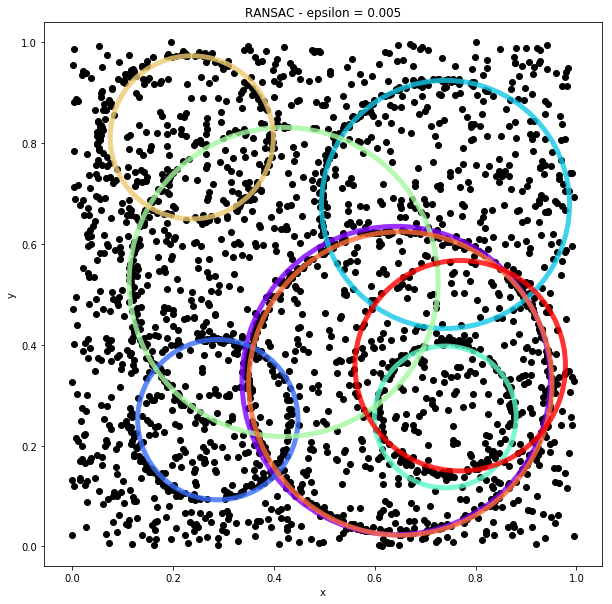

In [128]:
# plot results
plt.figure(figsize=(10,10))
plt.scatter(data[:,0],data[:,1],facecolor='k')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.title('RANSAC - epsilon = 0.005')

color=iter(cm.rainbow(np.linspace(0,1,len(circles))))

for C in circles:
    clr = next(color)
    circle = plt. Circle ((C[0] , C[1]), radius = C[2], color=clr, fill = False, lw=5, alpha = 0.8) # Create a circle
    plt.gca (). add_patch ( circle) # Add it to the plot
    #plt.legend()

We observe that the most of the circles are fitted well. There can be exeptions, where a fitted circle matches only a segment of the expected circle. The result is sensitive to $\epsilon$. If epsilon is chosen to small, less circles will be found. If it is to large, circles the data will be overfitted. This can be seen below.

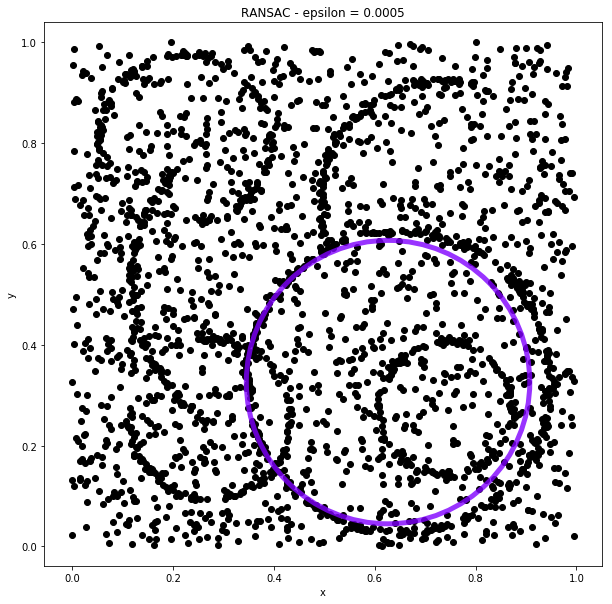

In [124]:
# apply ransac small epsilon
X = data[:,0]
Y = data[:,1]
N = int(N)
circles = ransac(X,Y,N,e=0.0005)
len(circles)

# plot results
plt.figure(figsize=(10,10))
plt.scatter(data[:,0],data[:,1],facecolor='k')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.title('RANSAC - epsilon = 0.0005')

color=iter(cm.rainbow(np.linspace(0,1,len(circles))))

for C in circles:
    clr = next(color)
    circle = plt. Circle ((C[0] , C[1]), radius = C[2], color=clr, fill = False, lw=5, alpha = 0.8) # Create a circle
    plt.gca (). add_patch ( circle) # Add it to the plot
    #plt.legend()

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less_equal


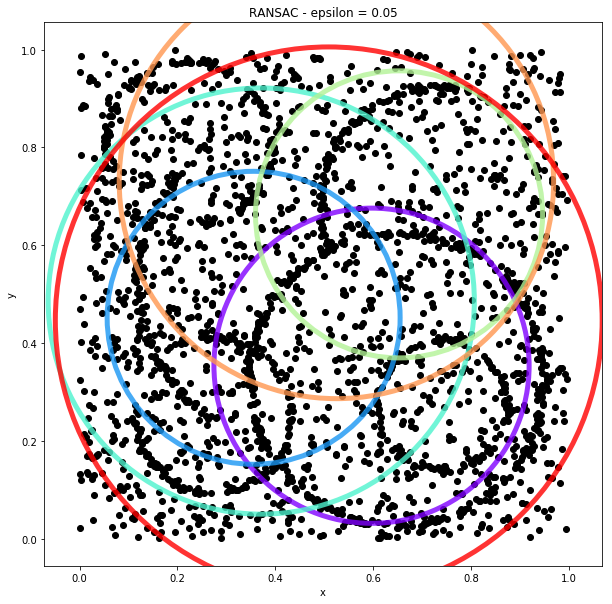

In [125]:
# apply ransac small epsilon
X = data[:,0]
Y = data[:,1]
N = int(N)
circles = ransac(X,Y,N,e=0.05)
len(circles)

# plot results
plt.figure(figsize=(10,10))
plt.scatter(data[:,0],data[:,1],facecolor='k')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.title('RANSAC - epsilon = 0.05')

color=iter(cm.rainbow(np.linspace(0,1,len(circles))))

for C in circles:
    clr = next(color)
    circle = plt. Circle ((C[0] , C[1]), radius = C[2], color=clr, fill = False, lw=5, alpha = 0.8) # Create a circle
    plt.gca (). add_patch ( circle) # Add it to the plot
    #plt.legend()

## 4.2 Algebraic Distance

### npoints=50
np.random.randint(0,npoints-1,3)
    
    

## 4.3 Levenberg-Marquardt

## 4.4 Comparison